## This is a demo notebook illustrating the use of the Welch percentile (WP) estimator

#### What is included in this notebook:
* Domenstrations on how to use the functions in wp.py
* Simulations illustrating the accuracy of the bias and variance equations

A theoretical discussion of the WP estimator can be found in [1]

[1] F. Schwock and S. Abadi, "Statistical Properties of a Modified Welch Method That Uses Sample Percentiles," ICASSP 2021 - 2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2021, pp. 5165-5169, doi: 10.1109/ICASSP39728.2021.9415074.

In [1]:
import wp
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import signal

## Demonstation of WP estimator
### Generating a test signal

The signal is a white Gaussian noise sequence with occasional pings that would make a spectral estimation difficult with traditional methods. For simplicity the pings are equally spaced in the sequence and have a rectangular shape

In [2]:
N = 51200
noise = np.random.randn(N) #white Gaussian noise with unit variance

# insert pings
pings = np.zeros(N)
npings = 3 #number of pings inserted
for i in range(npings):
    ping_start = int((i + 1) * N / (npings + 1))
    pings[ping_start:ping_start + 5] = 100.0
noise = noise + pings

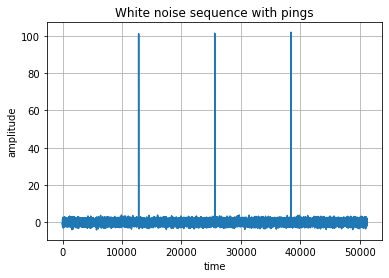

In [3]:
# plot time seies
plt.plot(noise)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('White noise sequence with pings')
plt.grid()
plt.show()

### Compute WP estimate and compare with standard Welch estimate

Now we use the WP estimator to compute the power speectral density (PSD) of the sequence shown in the previous plot. We also compare the result with the standard Welch method

The standard Welch method fails to give an accurate estimate of the noise level. In fact it looks more like a noisy sinc-square function due to the rectangular shaped pings in the signal. On the other hand, both the Welch-50th and Welch-80th percentiles estimator can give accurate estimates of the noise.

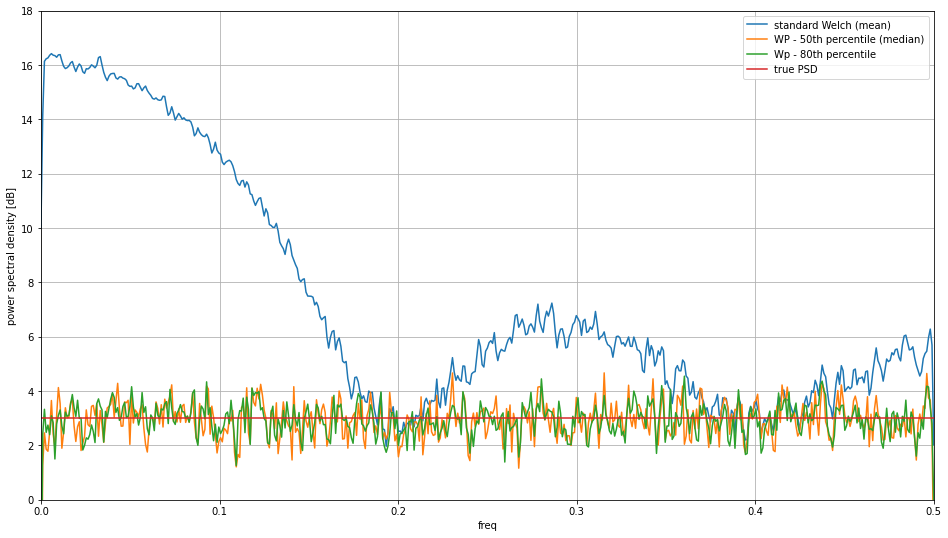

In [4]:
o = 0.5 # overlap
Ns = 1024 # number of samples in each segment

# standard Welch estimate
f, Pxx_welch, _ = wp.welch_percentile(noise, None, fs=1.0, window='hann',
                                      nperseg=Ns, overlap=o, percentile=None)

# Welch percentile estimate using median
f, Pxx_wp_05, _ = wp.welch_percentile(noise, wp.bias_digamma_approx, fs=1.0, window='hann',
                                      nperseg=Ns, overlap=o, percentile=0.5, percentage_outliers=0.03)

# Welch percentile estimate using 80th percentile
f, Pxx_wp_08, _ = wp.welch_percentile(noise, wp.bias_digamma_approx, fs=1.0, window='hann',
                                      nperseg=Ns, overlap=o, percentile=0.8, percentage_outliers=0.03)

fig, ax = plt.subplots(figsize=(16,9))
plt.plot(f, 10 * np.log10(Pxx_welch), label='standard Welch (mean)')
plt.plot(f, 10 * np.log10(Pxx_wp_05), label='WP - 50th percentile (median)')
plt.plot(f, 10 * np.log10(Pxx_wp_08), label='Wp - 80th percentile')
plt.plot(f, np.ones(len(f)) * 10 * np.log10(2), label='true PSD')
plt.xlabel('freq')
plt.ylabel('power spectral density [dB]')
plt.grid(True)
plt.ylim([0, 18])
plt.xlim(0,0.5)
plt.legend()
plt.show()

## Accuracy of WP bias and variance formulas

In the following we will evaluate the accuracy of the WP estimator. This sections essentially shows how to reproduce the figures in [1]. The plots in the paper were averaged over more realizations than used in this notebook.

The simulations are all performed as follows:
1. generate a white Gaussian noise sequence with given length and unit variance
2. apply the WP estimator with differnt parameters (different bias correction functions, percentiles etc.)
3. estimate the bias (or variance) of the resulting WP estimate
4. repeat 1-3 for multiple realizations and differnt sequence lengths
5. compare numerical results with theoretical formulas.

### Compare differnt bias correction functions

First we compare differnt bias correction functions. To do so, we apply different bias correction functions when computing the WP estimate and plot the remaining bias of the spectral estimate.

In [5]:
Ns = 1024 # number samples per segment
overlap = 0.5
window = 'hann'
percentile = 0.5
Nb_list = np.arange(3, 201, 1) # list with number of segments
n_trial = 10 # number of random trials

avg_bias_ahs = [] # average remaining bias after applying Eq. (7) in [1]
avg_bias_ths = [] # average remaining bias after applying Eq. (15) in [1]
avg_bias_dga = [] # average remaining bias after applying Eq. (17) in [1]
avg_bias_limit = [] # aaverage remaining bias after applying the limit bias b = -ln(1-q)

for i in tqdm(Nb_list):
    ahs = 0
    ths = 0
    dga = 0
    limit = 0
    for _ in range(n_trial):
        N = int((i + 1) * overlap * Ns) # signal length
        e = np.random.randn(N) # white Gaussian noise
        
        # Welch percentile estimate and alternating harmonic series for bias correction
        f, pxx_ahs, Nb = wp.welch_percentile(e, wp.bias_alternating_harmonic_series,
                                             window=window, nperseg=Ns, percentile=percentile,
                                             fs=1.0, overlap=overlap, return_onesided=False)
        
        # Welch percentile estimate and truncated harmonic series for bias correction
        f, pxx_ths, Nb = wp.welch_percentile(e, wp.bias_truncated_harmonic_series,
                                             window=window, nperseg=Ns, percentile=percentile,
                                             fs=1.0, overlap=overlap, return_onesided=False)
        
        # Welch percentile estimate and digamma approximation for bias correction
        f, pxx_dga, Nb = wp.welch_percentile(e, wp.bias_digamma_approx,
                                             window=window, nperseg=Ns, percentile=percentile,
                                             fs=1.0, overlap=overlap, return_onesided=False)
        
        # Welch percentile estimate and limit for bias correction
        f, pxx_limit, Nb = wp.welch_percentile(e, wp.bias_limit,
                                               window=window, nperseg=Ns, percentile=percentile,
                                               fs=1.0, overlap=overlap, return_onesided=False)
            
        # since we use white noise we can average over all frequencies except for f = 0 and f = fs
        # to get a better estimate of the remaining bias
        ahs += 1/n_trial * np.mean(pxx_ahs[1:512])
        ths += 1/n_trial * np.mean(pxx_ths[1:512])
        dga += 1/n_trial * np.mean(pxx_dga[1:512])
        limit += 1/n_trial * np.mean(pxx_limit[1:512])
     
        
    avg_bias_ahs.append(ahs)
    avg_bias_ths.append(ths)
    avg_bias_dga.append(dga)
    avg_bias_limit.append(limit)
    
avg_bias_ahs = np.array(avg_bias_ahs)
avg_bias_ths = np.array(avg_bias_ths)
avg_bias_dga = np.array(avg_bias_dga)
avg_bias_limit = np.array(avg_bias_limit)

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [01:07<00:00,  2.93it/s]


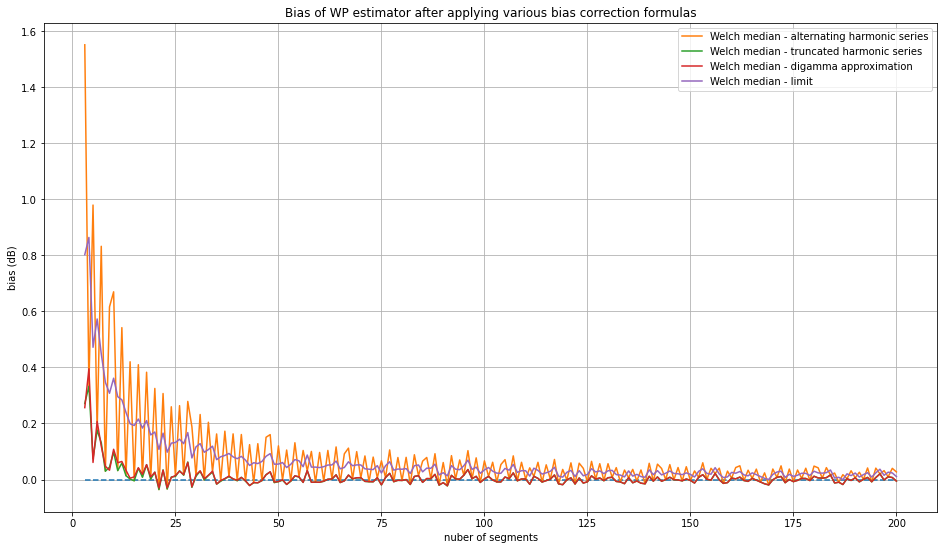

In [6]:
# plot the remaining bias vs. Nb
fig = plt.figure(figsize=(16,9))
plt.plot(Nb_list, np.zeros(len(Nb_list)), linestyle='dashed')
plt.plot(Nb_list, 10 * np.log10(avg_bias_ahs),label='Welch median - alternating harmonic series')
plt.plot(Nb_list, 10 * np.log10(avg_bias_ths),label='Welch median - truncated harmonic series')
plt.plot(Nb_list, 10 * np.log10(avg_bias_dga),label='Welch median - digamma approximation')
plt.plot(Nb_list, 10 * np.log10(avg_bias_limit),label='Welch median - limit')

plt.xlabel('nuber of segments')
plt.ylabel('bias (dB)')
plt.legend()
plt.title('Bias of WP estimator after applying various bias correction formulas')
plt.grid(True)
#plt.ylim([-0.1, 0.4])
plt.show()

### Compare remainig bias for differnt percentiles

Next we compare the performance of the bias correction for different percentiles. For the bias correction, we use the digamma approximation as this gives very accurate results for any combination of number of segments and percentiles.

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:18<00:00, 10.92it/s]


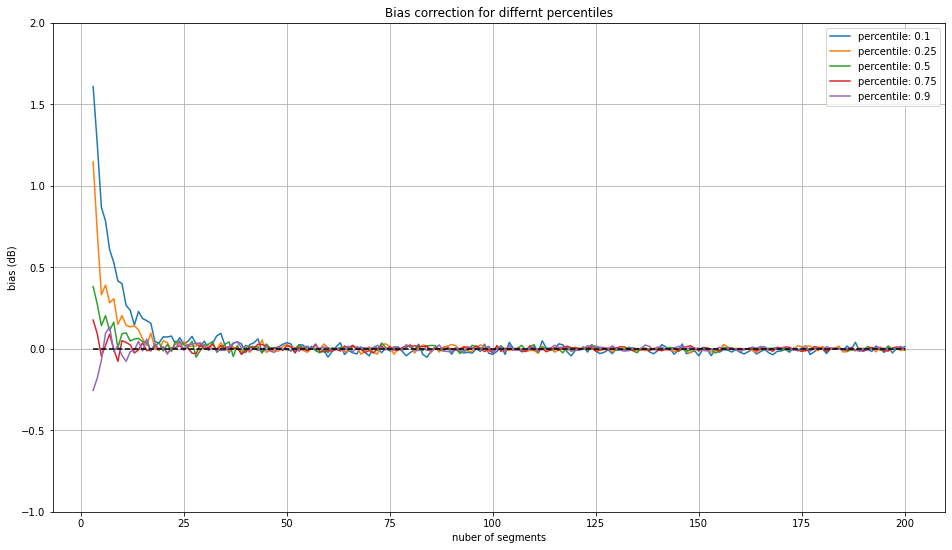

In [7]:
Ns = 1024 # number samples per segment
overlap = 0.5
window = 'hann'
Nb_list = np.arange(3, 201, 1) # list with number of segments
n_trial = 10 # number of random trials

percentiles = np.array([0.1, 0.25, 0.5, 0.75, 0.9]) #percentiles
fig, ax = plt.subplots(figsize=(16,9))
for k, p in enumerate(percentiles):
    avg_bias_dga = [] # average remaining bias after applying Eq. (17) in [1]
    for i in tqdm(Nb_list):
        dga = 0
        for _ in range(n_trial):
            N = int((i + 1) * overlap * Ns) # signal length
            e = np.random.randn(N) # white Gaussian noise

            # Welch percentile estimate and digamma approximation for bias correction
            f, pxx_dga, Nb = wp.welch_percentile(e, wp.bias_digamma_approx,
                                                 window=window, nperseg=Ns, percentile=p,
                                                 fs=1.0, overlap=overlap, return_onesided=False)

            # since we use white noise we can average over all frequencies except for f = 0 and f = fs
            # to get a better estimate of the remaining bias
            dga += 1/n_trial * np.mean(pxx_dga[1:512])
        avg_bias_dga.append(dga)

    avg_bias_dga = np.array(avg_bias_dga)
    plt.plot(Nb_list, 10 * np.log10(avg_bias_dga), label='percentile: ' + str(p))
    
plt.plot(Nb_list, np.zeros(len(Nb_list)), linestyle='dashed', color='black')
plt.xlabel('nuber of segments')
plt.ylabel('bias (dB)')
plt.legend()
plt.title('Bias correction for differnt percentiles')
plt.grid(True)
plt.ylim([-1,2])
plt.show()

### Compare variance of WP estimator with theoretical expressions

Last, we compare numerical values of the WP estimator's variance with the theoretical expressions derived in [1] for various percentiles. For the bias correction, we use the digamma approximation.

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:18<00:00, 10.65it/s]


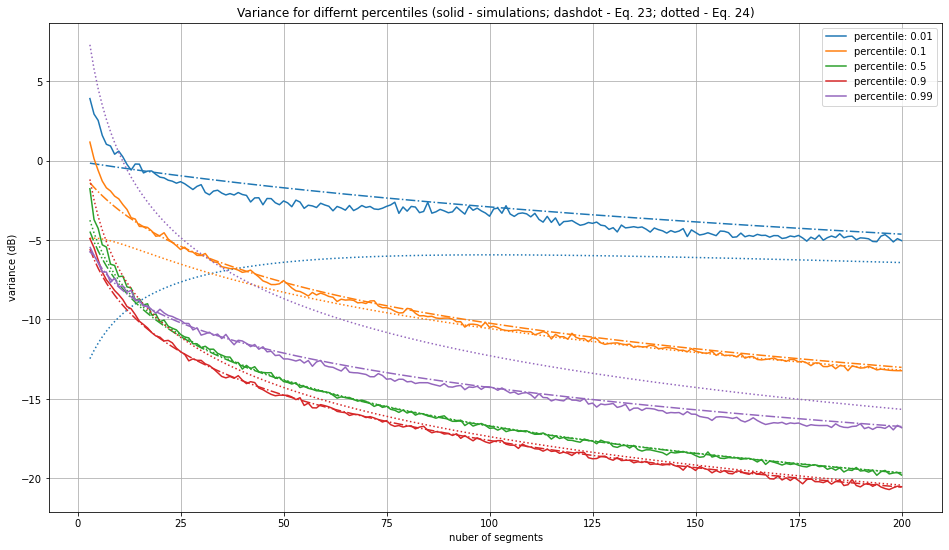

In [8]:
Ns = 1024 # number samples per segment
overlap = 0.5
window = 'hann'
Nb_list = np.arange(3, 201, 1) # list with number of segments
n_trial = 10 # number of random trials
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

percentiles = np.array([0.01, 0.1, 0.5, 0.9, 0.99]) #percentiles
fig, ax = plt.subplots(figsize=(16,9))
for k, p in enumerate(percentiles):
    avg_var = [] # average variance from simulations
    var_tga = [] # variance according to Eq. 23 in [1]
    var_limit = [] # variance according to Eq. 24 in [1]
    for i in tqdm(Nb_list):
        var = 0
        N = int((i + 1) * overlap * Ns) # signal length
        
        # compute the equivalent degree of freedom, which is needed to compute the variance
        win = signal.hann(Ns, False) / np.sqrt(np.sum(signal.hann(Ns, False)**2))
        edof = wp.compute_nu(N, Ns, win, overlap)
        bias = wp.bias_digamma_approx(edof/2, p, 0)
        
        for _ in range(n_trial):
            e = np.random.randn(N) # white Gaussian noise

            # Welch percentile estimate and digamma approximation for bias correction
            f, pxx_dga, Nb = wp.welch_percentile(e, wp.bias_digamma_approx,
                                                 window=window, nperseg=Ns, percentile=p,
                                                 fs=1.0, overlap=overlap, return_onesided=False)

            # since we use white noise we can take the sample variance over all frequencies
            # except for f = 0 and f = fs to get a better estimate of the estimators variance
            var += 1/n_trial * np.var(pxx_dga[1:512])
        avg_var.append(var)
        var_tga.append(wp.var_welch_percentile(edof/2, p, bias, 0))
        var_limit.append(wp.var_welch_percentile_limit(edof/2, p, bias, 0))

    avg_var = np.array(avg_var)
    var_tga = np.array(var_tga)
    var_limit = np.array(var_limit)
    
    plt.plot(Nb_list, 10 * np.log10(avg_var), label='percentile: ' + str(p), color=colors[k])
    plt.plot(Nb_list, 10 * np.log10(var_tga), linestyle='dashdot', color=colors[k])
    plt.plot(Nb_list, 10 * np.log10(var_limit), linestyle='dotted', color=colors[k])
    
    
plt.xlabel('nuber of segments')
plt.ylabel('variance (dB)')
plt.legend()
plt.title('Variance for differnt percentiles (solid - simulations; dashdot - Eq. 23; dotted - Eq. 24)')
plt.grid(True)
plt.show()